### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits, fetch_olivetti_faces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from torchsummary import summary

seed_value = 12345

# Autoencoder

### Loading digits dataset from Scikit-learn

In [ ]:
digits = load_digits()
X = digits.images / 16.0
y = digits.target

print("Shape of dataset images:", X.shape)
print("Shape of dataset labels:", y.shape)

print("Minimum pixel value of dataset images:", np.min(X))
print("Maximum pixel value of dataset images:", np.max(X))
print("Minimum label value of dataset images:", np.min(y))
print("Maximum label value of dataset images:", np.max(y))

Shape of dataset images: (1797, 8, 8)
Shape of dataset labels: (1797,)
Minimum pixel value of dataset images: 0.0
Maximum pixel value of dataset images: 1.0
Minimum label value of dataset images: 0
Maximum label value of dataset images: 9


### Visualization of some samples from the dataset

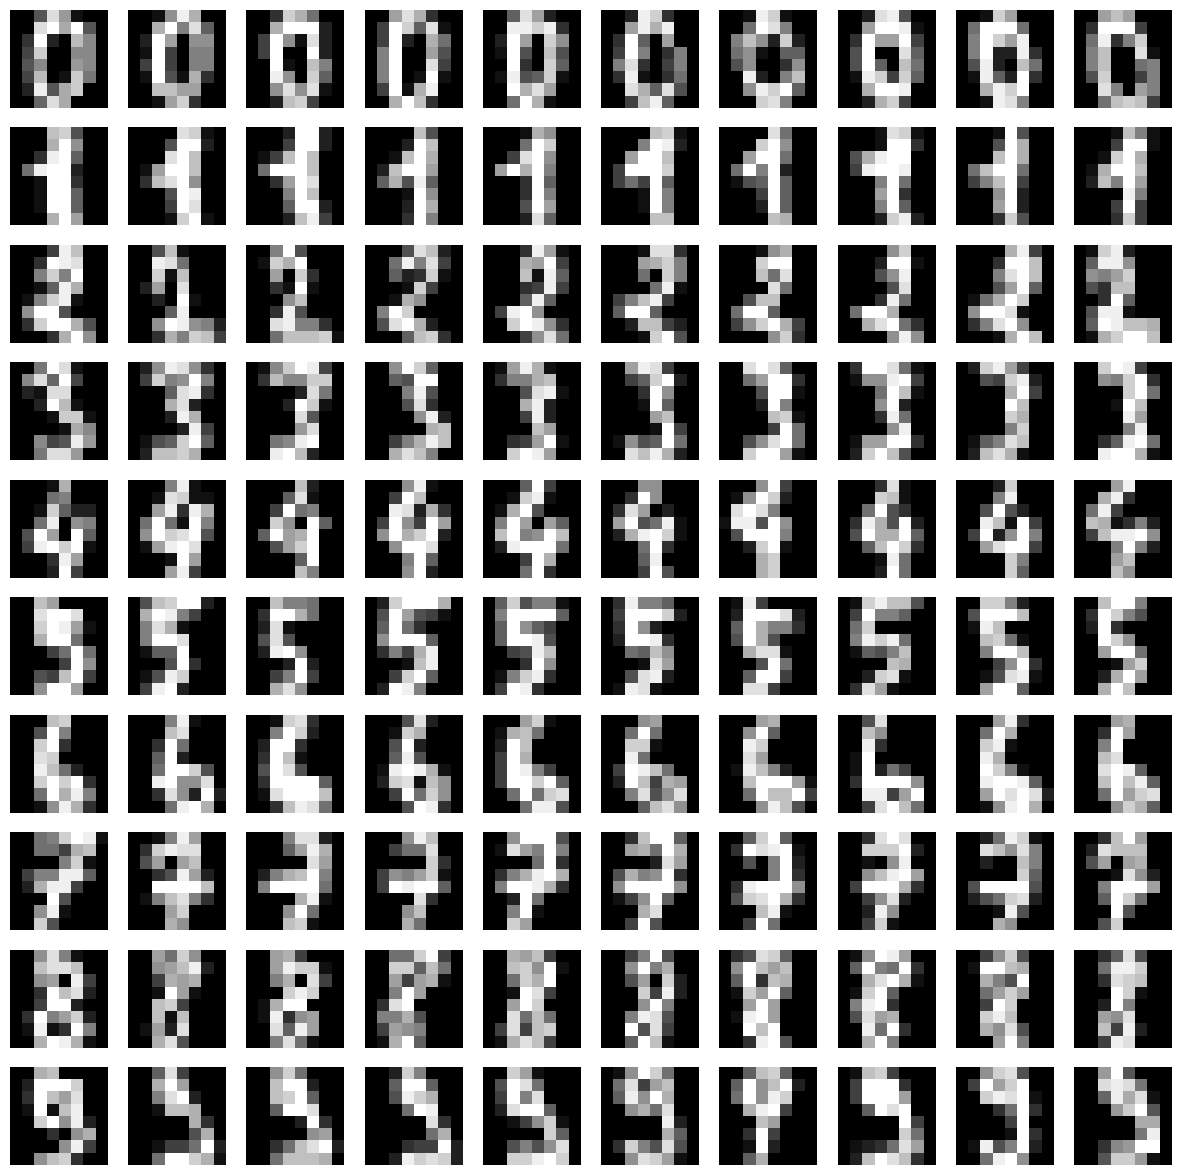

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))

for digit_idx in range(10):
  occurance_idx_array = np.where(y == digit_idx)

  for j in range(10):
    ax[digit_idx, j].imshow(X[occurance_idx_array[0][j]], cmap='gray')
    ax[digit_idx, j].axis('off')

plt.show()

### Dividing the dataset into train, validation and test sets

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed_value*1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed_value*2)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1257, 8, 8)
(270, 8, 8)
(270, 8, 8)
(1257,)
(270,)
(270,)


### Creating a noisy version of the dataset

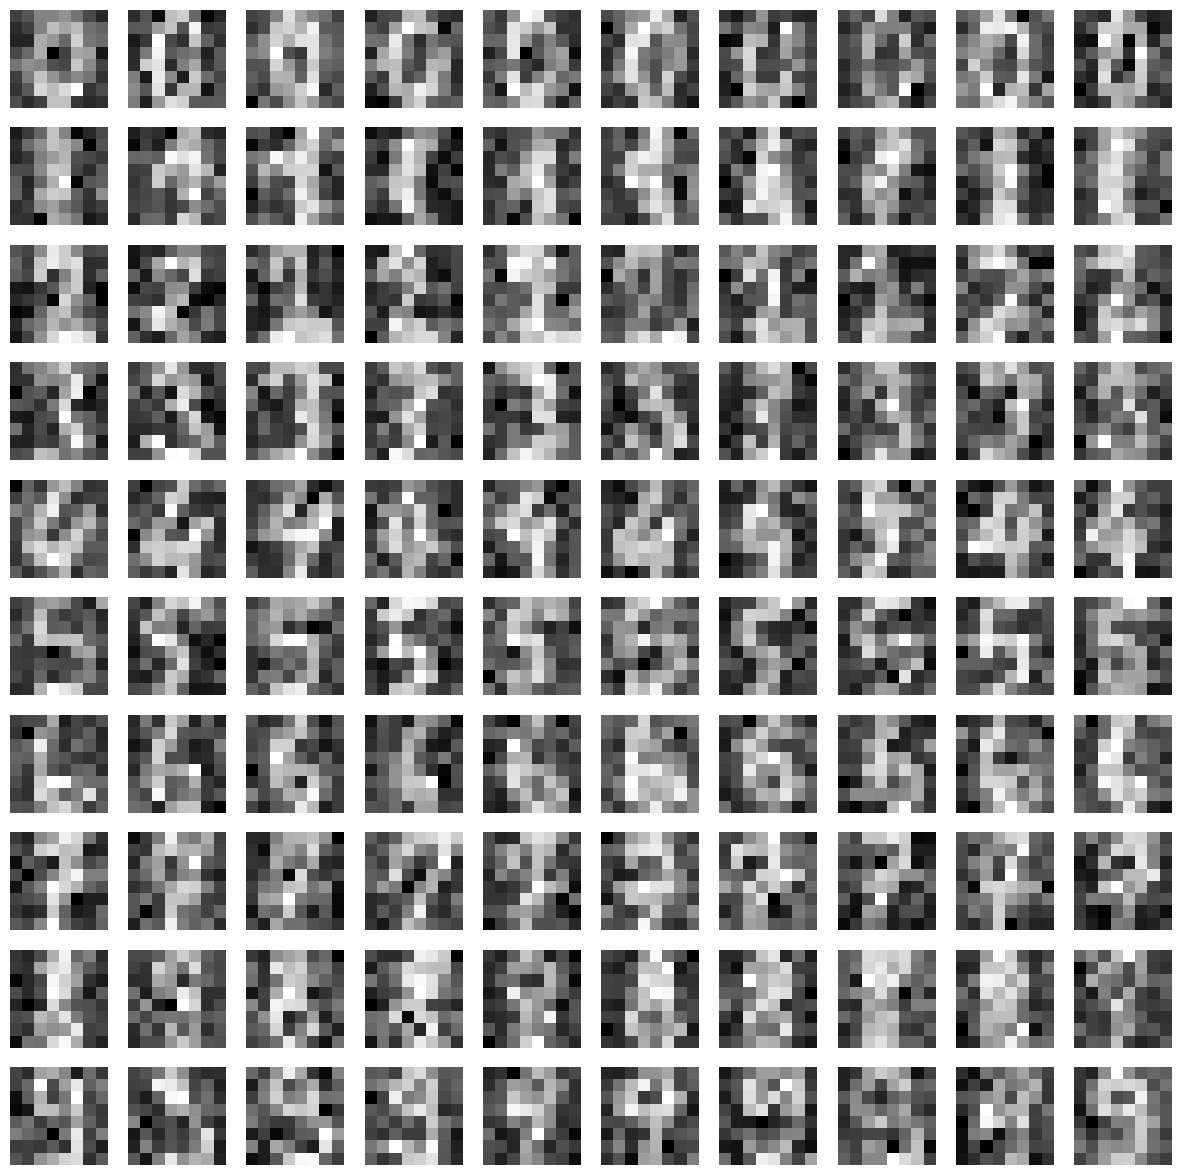

In [ ]:
np.random.seed(seed_value*3)
torch.manual_seed(seed_value*4)

def add_gaussian_noise(images, mean=0.0, std=1.0):
  noisy_images = images + np.random.normal(loc=mean, scale=std, size=images.shape)
  return noisy_images

X_train_noisy = add_gaussian_noise(X_train, mean=0.0, std=0.2)
X_val_noisy = add_gaussian_noise(X_val, mean=0.0, std=0.2)
X_test_noisy = add_gaussian_noise(X_test, mean=0.0, std=0.2)

fig, ax = plt.subplots(10, 10, figsize=(15, 15))

for digit_idx in range(10):
  occurance_idx_array = np.where(y_train == digit_idx)

  for j in range(10):
    ax[digit_idx, j].imshow(X_train_noisy[occurance_idx_array[0][j]], cmap='gray')
    ax[digit_idx, j].axis('off')

plt.show()

### Designing the denoising autoencoder

In [ ]:
class DenoisingAutoEncoder(nn.Module):
  def __init__(self, input_channels=1, out_channels=1, num_kernels=4):
    super().__init__()

    self.encode_conv_1_1 = nn.Conv2d(in_channels=input_channels, out_channels=num_kernels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.encode_conv_1_2 = nn.Conv2d(in_channels=num_kernels, out_channels=num_kernels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.encode_conv_2_1 = nn.Conv2d(in_channels=num_kernels, out_channels=num_kernels*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.encode_conv_2_2 = nn.Conv2d(in_channels=num_kernels*2, out_channels=num_kernels*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.encode_conv_3_1 = nn.Conv2d(in_channels=num_kernels*2, out_channels=num_kernels*4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.encode_conv_3_2 = nn.Conv2d(in_channels=num_kernels*4, out_channels=num_kernels*4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.bottleneck_conv_1 = nn.Conv2d(in_channels=num_kernels*4, out_channels=num_kernels*8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.bottleneck_conv_2 = nn.Conv2d(in_channels=num_kernels*8, out_channels=num_kernels*8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.decode_transpose_conv_1 = nn.ConvTranspose2d(in_channels=num_kernels*8, out_channels=num_kernels*4, kernel_size=(2, 2), stride=(2, 2))
    self.decode_conv_1_1 = nn.Conv2d(in_channels=num_kernels*4, out_channels=num_kernels*4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.decode_conv_1_2 = nn.Conv2d(in_channels=num_kernels*4, out_channels=num_kernels*4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.decode_transpose_conv_2 = nn.ConvTranspose2d(in_channels=num_kernels*4, out_channels=num_kernels*2, kernel_size=(2, 2), stride=(2, 2))
    self.decode_conv_2_1 = nn.Conv2d(in_channels=num_kernels*2, out_channels=num_kernels*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.decode_conv_2_2 = nn.Conv2d(in_channels=num_kernels*2, out_channels=num_kernels*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.decode_transpose_conv_3 = nn.ConvTranspose2d(in_channels=num_kernels*2, out_channels=num_kernels, kernel_size=(2, 2), stride=(2, 2))
    self.decode_conv_3_1 = nn.Conv2d(in_channels=num_kernels, out_channels=num_kernels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.decode_conv_3_2 = nn.Conv2d(in_channels=num_kernels, out_channels=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.maxpool = nn.MaxPool2d((2, 2))

  def encode(self, input):
    output = self.relu(self.encode_conv_1_1(input))
    output = self.relu(self.encode_conv_1_2(output))
    output = self.maxpool(output)

    output = self.relu(self.encode_conv_2_1(output))
    output = self.relu(self.encode_conv_2_2(output))
    output = self.maxpool(output)

    output = self.relu(self.encode_conv_3_1(output))
    output = self.relu(self.encode_conv_3_2(output))
    output = self.maxpool(output)

    output = self.relu(self.bottleneck_conv_1(output))
    output = self.relu(self.bottleneck_conv_2(output))

    return output

  def decode(self, latent):
    output = self.relu(self.decode_transpose_conv_1(latent))
    output = self.relu(self.decode_conv_1_1(output))
    output = self.relu(self.decode_conv_1_2(output))

    output = self.relu(self.decode_transpose_conv_2(output))
    output = self.relu(self.decode_conv_2_1(output))
    output = self.relu(self.decode_conv_2_2(output))

    output = self.relu(self.decode_transpose_conv_3(output))
    output = self.relu(self.decode_conv_3_1(output))
    output = self.sigmoid(self.decode_conv_3_2(output))

    return output

  def forward(self, input):
    latent = self.encode(input)
    output = self.decode(latent)

    return output

ae_model = DenoisingAutoEncoder().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("Autoencoder Model Summary:")
summary(ae_model, (1, 8, 8))

Autoencoder Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 4, 8, 8]              40
              ReLU-2              [-1, 4, 8, 8]               0
            Conv2d-3              [-1, 4, 8, 8]             148
              ReLU-4              [-1, 4, 8, 8]               0
         MaxPool2d-5              [-1, 4, 4, 4]               0
            Conv2d-6              [-1, 8, 4, 4]             296
              ReLU-7              [-1, 8, 4, 4]               0
            Conv2d-8              [-1, 8, 4, 4]             584
              ReLU-9              [-1, 8, 4, 4]               0
        MaxPool2d-10              [-1, 8, 2, 2]               0
           Conv2d-11             [-1, 16, 2, 2]           1,168
             ReLU-12             [-1, 16, 2, 2]               0
           Conv2d-13             [-1, 16, 2, 2]           2,320
            

### Defining hyperparameters, dataloaders and reconstruction loss

In [ ]:
np.random.seed(seed_value*5)
torch.manual_seed(seed_value*6)

batch_size = 2
learning_rate = 1.0e-3
num_epochs = 500

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_train_noisy_tensor = torch.tensor(X_train_noisy, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_val_noisy_tensor = torch.tensor(X_val_noisy, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
X_test_noisy_tensor = torch.tensor(X_test_noisy, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_noisy_tensor, X_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_noisy_tensor, X_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_noisy_tensor, X_test_tensor), batch_size=batch_size)

criterion = nn.MSELoss()

### Model initialization, optimizer definition, training and loss visualization

Epoch 1/500, Train Loss: 0.0869, Val Loss: 0.0750, Time: 4.8
Epoch 2/500, Train Loss: 0.0742, Val Loss: 0.0748, Time: 9.3
Epoch 3/500, Train Loss: 0.0735, Val Loss: 0.0745, Time: 15.6
Epoch 4/500, Train Loss: 0.0726, Val Loss: 0.0729, Time: 21.6
Epoch 5/500, Train Loss: 0.0720, Val Loss: 0.0723, Time: 26.8
Epoch 6/500, Train Loss: 0.0710, Val Loss: 0.0711, Time: 31.8
Epoch 7/500, Train Loss: 0.0698, Val Loss: 0.0695, Time: 35.8
Epoch 8/500, Train Loss: 0.0682, Val Loss: 0.0682, Time: 39.7
Epoch 9/500, Train Loss: 0.0664, Val Loss: 0.0661, Time: 43.3
Epoch 10/500, Train Loss: 0.0647, Val Loss: 0.0664, Time: 46.9
Epoch 11/500, Train Loss: 0.0637, Val Loss: 0.0648, Time: 51.0
Epoch 12/500, Train Loss: 0.0624, Val Loss: 0.0636, Time: 54.6
Epoch 13/500, Train Loss: 0.0618, Val Loss: 0.0618, Time: 58.1
Epoch 14/500, Train Loss: 0.0608, Val Loss: 0.0621, Time: 62.2
Epoch 15/500, Train Loss: 0.0606, Val Loss: 0.0591, Time: 65.8
Epoch 16/500, Train Loss: 0.0587, Val Loss: 0.0580, Time: 69.4
Epo

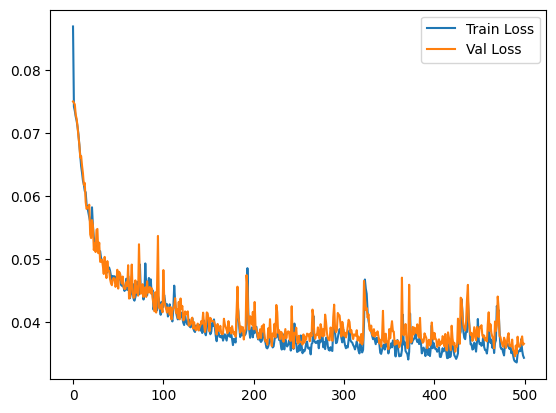

In [ ]:
np.random.seed(seed_value*7)
torch.manual_seed(seed_value*8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoEncoder().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()
train_losses, val_losses = [], []
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  for noisy_imgs, clean_imgs in train_loader:
    noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

    outputs = model(noisy_imgs)
    loss = criterion(outputs, clean_imgs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_losses.append(train_loss / len(train_loader))

  model.eval()
  val_loss = 0
  with torch.no_grad():
    for noisy_imgs, clean_imgs in val_loader:
      noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
      outputs = model(noisy_imgs)
      loss = criterion(outputs, clean_imgs)
      val_loss += loss.item()

  val_losses.append(val_loss / len(val_loader))
  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Time: {time.time() - start_time:.1f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

### Visualization of test outputs

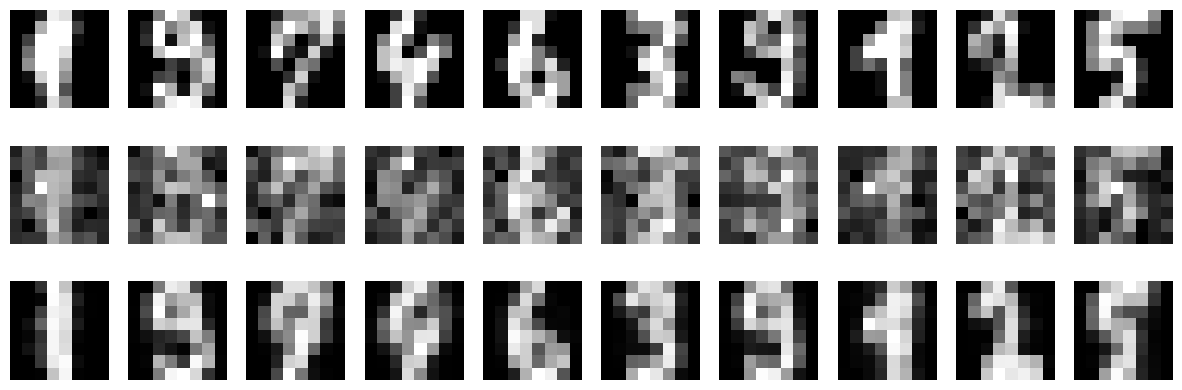

In [ ]:
model.eval()
denoised_imgs = []
with torch.no_grad():
  for noisy_imgs, _ in test_loader:
    noisy_imgs = noisy_imgs.to(device)
    outputs = model(noisy_imgs)
    denoised_imgs.append(outputs.cpu())

denosed_imgs = torch.cat(denoised_imgs).numpy()

fig, ax = plt.subplots(3, 10, figsize=(15, 5))

for i in range(10):
  ax[0, i].imshow(X_test[i].squeeze(), cmap='gray')
  ax[1, i].imshow(X_test_noisy[i].squeeze(), cmap='gray')
  ax[2, i].imshow(denosed_imgs[i].squeeze(), cmap='gray')

  for axes in ax[:, i]:
    axes.axis('off')

plt.show()

### Quantitative evaluation for denoising using autoencoder

In [ ]:
print(X_test.shape)
print(X_test_noisy.shape)
print(denosed_imgs.squeeze().shape)

mse_before = np.mean((X_test - X_test_noisy) ** 2)
mse_after = np.mean((X_test - denosed_imgs.squeeze()) ** 2)

print(f'MSE before denoising: {mse_before:.4f}')
print(f'MSE after denoising: {mse_after:.4f}')

(270, 8, 8)
(270, 8, 8)
(270, 8, 8)
MSE before denoising: 0.0399
MSE after denoising: 0.0384


# Variational Autoencoder (VAE)

### Loading Olivetti Faces dataset from Scikit-learn and visualization of some samples from the dataset

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Shape of dataset images: (400, 64, 64)
Shape of dataset labels: (400,)
Minimum pixel value of dataset images: 0.0
Maximum pixel value of dataset images: 1.0
Minimum label value of dataset images: 0
Maximum label value of dataset images: 39


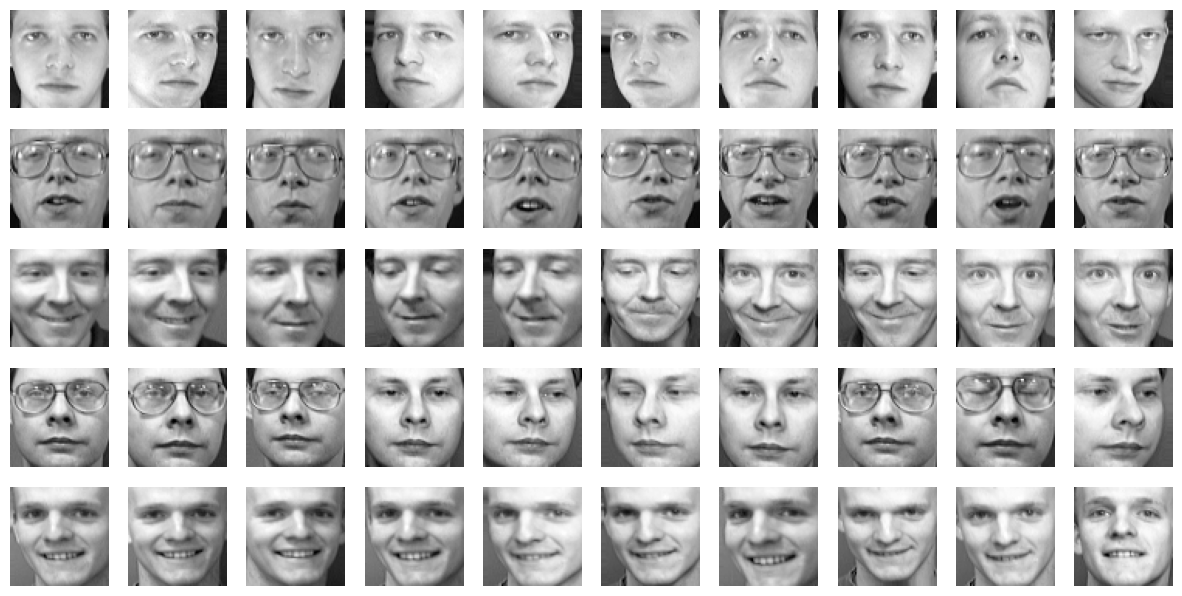

In [ ]:
faces = fetch_olivetti_faces()

X = faces.data.reshape(400, 64, 64)
y = faces.target

print("Shape of dataset images:", X.shape)
print("Shape of dataset labels:", y.shape)

print("Minimum pixel value of dataset images:", np.min(X))
print("Maximum pixel value of dataset images:", np.max(X))
print("Minimum label value of dataset images:", np.min(y))
print("Maximum label value of dataset images:", np.max(y))

fig, ax = plt.subplots(5, 10, figsize=(15, 7.5))

for digit_idx in range(5):
  occurance_idx_array = np.where(y == digit_idx)

  for j in range(10):
    ax[digit_idx, j].imshow(X[occurance_idx_array[0][j]], cmap='gray')
    ax[digit_idx, j].axis('off')

plt.show()

### Designing the VAE

In [ ]:
class VariationalAutoEncoder(nn.Module):
  def __init__(self, input_channels=1, out_channels=1, num_kernels=4):
    super().__init__()

    self.encode_conv_1_1 = nn.Conv2d(in_channels=input_channels, out_channels=num_kernels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.encode_conv_1_2 = nn.Conv2d(in_channels=num_kernels, out_channels=num_kernels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.encode_conv_2_1 = nn.Conv2d(in_channels=num_kernels, out_channels=num_kernels*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.encode_conv_2_2 = nn.Conv2d(in_channels=num_kernels*2, out_channels=num_kernels*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.encode_conv_3_1 = nn.Conv2d(in_channels=num_kernels*2, out_channels=num_kernels*4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.encode_conv_3_2 = nn.Conv2d(in_channels=num_kernels*4, out_channels=num_kernels*4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.bottleneck_conv_1 = nn.Conv2d(in_channels=num_kernels*4, out_channels=num_kernels*8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.bottleneck_conv_2_mu = nn.Conv2d(in_channels=num_kernels*8, out_channels=num_kernels*8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.bottleneck_conv_2_sigma = nn.Conv2d(in_channels=num_kernels*8, out_channels=num_kernels*8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.decode_transpose_conv_1 = nn.ConvTranspose2d(in_channels=num_kernels*8, out_channels=num_kernels*4, kernel_size=(2, 2), stride=(2, 2))
    self.decode_conv_1_1 = nn.Conv2d(in_channels=num_kernels*4, out_channels=num_kernels*4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.decode_conv_1_2 = nn.Conv2d(in_channels=num_kernels*4, out_channels=num_kernels*4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.decode_transpose_conv_2 = nn.ConvTranspose2d(in_channels=num_kernels*4, out_channels=num_kernels*2, kernel_size=(2, 2), stride=(2, 2))
    self.decode_conv_2_1 = nn.Conv2d(in_channels=num_kernels*2, out_channels=num_kernels*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.decode_conv_2_2 = nn.Conv2d(in_channels=num_kernels*2, out_channels=num_kernels*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.decode_transpose_conv_3 = nn.ConvTranspose2d(in_channels=num_kernels*2, out_channels=num_kernels, kernel_size=(2, 2), stride=(2, 2))
    self.decode_conv_3_1 = nn.Conv2d(in_channels=num_kernels, out_channels=num_kernels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')
    self.decode_conv_3_2 = nn.Conv2d(in_channels=num_kernels, out_channels=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='replicate')

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.maxpool = nn.MaxPool2d((2, 2))

  def encode(self, input):
    output = self.relu(self.encode_conv_1_1(input))
    output = self.relu(self.encode_conv_1_2(output))
    output = self.maxpool(output)

    output = self.relu(self.encode_conv_2_1(output))
    output = self.relu(self.encode_conv_2_2(output))
    output = self.maxpool(output)

    output = self.relu(self.encode_conv_3_1(output))
    output = self.relu(self.encode_conv_3_2(output))
    output = self.maxpool(output)

    output = self.relu(self.bottleneck_conv_1(output))
    mu = self.relu(self.bottleneck_conv_2_mu(output))
    log_var = self.relu(self.bottleneck_conv_2_sigma(output))

    return mu, log_var

  def decode(self, latent):
    output = self.relu(self.decode_transpose_conv_1(latent))
    output = self.relu(self.decode_conv_1_1(output))
    output = self.relu(self.decode_conv_1_2(output))

    output = self.relu(self.decode_transpose_conv_2(output))
    output = self.relu(self.decode_conv_2_1(output))
    output = self.relu(self.decode_conv_2_2(output))

    output = self.relu(self.decode_transpose_conv_3(output))
    output = self.relu(self.decode_conv_3_1(output))
    output = self.sigmoid(self.decode_conv_3_2(output))

    return output

  def forward(self, input):
    mu, log_var = self.encode(input)
    std = torch.exp(0.5 * log_var)
    epsilon = torch.randn_like(std)
    latent = mu + (std * epsilon)
    output = self.decode(latent)

    return output, mu, log_var

vae_model = VariationalAutoEncoder().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("Variational Autoencoder Model Summary:")
summary(vae_model, (1, 64, 64))

Variational Autoencoder Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 64, 64]              40
              ReLU-2            [-1, 4, 64, 64]               0
            Conv2d-3            [-1, 4, 64, 64]             148
              ReLU-4            [-1, 4, 64, 64]               0
         MaxPool2d-5            [-1, 4, 32, 32]               0
            Conv2d-6            [-1, 8, 32, 32]             296
              ReLU-7            [-1, 8, 32, 32]               0
            Conv2d-8            [-1, 8, 32, 32]             584
              ReLU-9            [-1, 8, 32, 32]               0
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,168
             ReLU-12           [-1, 16, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]           2,320


### Defining hyperparameters, dataloader and VAE loss (sum of reconstruction loss and KL-divergence loss)

In [ ]:
np.random.seed(seed_value*9)
torch.manual_seed(seed_value*10)

batch_size = 2
learning_rate = 1.0e-3
num_epochs = 500

X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=True)

def vae_loss(output, target, mu, log_var, beta=1.0):
  recon_criterion = nn.MSELoss()
  recon_loss = recon_criterion(output, target)
  kl_div_loss = torch.sum(0.5 * (log_var.exp() + mu.pow(2) - 1.0 - log_var))

  return recon_loss + (beta * kl_div_loss), recon_loss, (beta * kl_div_loss)

### Model initialization, optimizer definition and training

In [ ]:
np.random.seed(seed_value*11)
torch.manual_seed(seed_value*12)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VariationalAutoEncoder().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()
train_losses = []
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  recon_loss_total = 0
  kl_div_loss_total = 0
  for clean_imgs, _ in train_loader:
    clean_imgs = clean_imgs.to(device)

    outputs, mu, log_var = model(clean_imgs)
    loss, recon_loss, kl_div_loss = vae_loss(outputs, clean_imgs, mu, log_var, beta=(1.0e-8 + ((epoch / num_epochs) * 1.0e-5)))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    recon_loss_total += recon_loss.item()
    kl_div_loss_total += kl_div_loss.item()

  train_losses.append(train_loss / len(train_loader))

  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Recon loss: {(recon_loss_total/len(train_loader)):.4f}, KL-div loss: {(kl_div_loss_total/len(train_loader)):.4f}, Time: {time.time() - start_time:.1f}")

Epoch 1/500, Train Loss: 0.0299, Recon loss: 0.0299, KL-div loss: 0.0000, Time: 1.7
Epoch 2/500, Train Loss: 0.0168, Recon loss: 0.0166, KL-div loss: 0.0002, Time: 3.3
Epoch 3/500, Train Loss: 0.0094, Recon loss: 0.0092, KL-div loss: 0.0003, Time: 4.9
Epoch 4/500, Train Loss: 0.0082, Recon loss: 0.0079, KL-div loss: 0.0004, Time: 6.5
Epoch 5/500, Train Loss: 0.0078, Recon loss: 0.0073, KL-div loss: 0.0004, Time: 8.4
Epoch 6/500, Train Loss: 0.0077, Recon loss: 0.0072, KL-div loss: 0.0005, Time: 10.4
Epoch 7/500, Train Loss: 0.0075, Recon loss: 0.0070, KL-div loss: 0.0005, Time: 11.9
Epoch 8/500, Train Loss: 0.0073, Recon loss: 0.0068, KL-div loss: 0.0005, Time: 13.7
Epoch 9/500, Train Loss: 0.0072, Recon loss: 0.0066, KL-div loss: 0.0006, Time: 15.3
Epoch 10/500, Train Loss: 0.0070, Recon loss: 0.0065, KL-div loss: 0.0006, Time: 16.9
Epoch 11/500, Train Loss: 0.0070, Recon loss: 0.0064, KL-div loss: 0.0006, Time: 18.4
Epoch 12/500, Train Loss: 0.0069, Recon loss: 0.0063, KL-div loss: 0

### Construction of new face samples

In [ ]:
np.random.seed(seed_value*13)
torch.manual_seed(seed_value*14)

model.eval()
input_imgs, latent_tensors, output_imgs = [], [], []
input_label_idx = 0
with torch.no_grad():
  for input_label_idx in range(10):
    input_found_flag = False
    for input_samples, input_labels in train_loader:
      if not input_found_flag:
        if input_labels[0] == input_label_idx:
          input_found_flag = True

          input_imgs.append(input_samples[0].cpu())
          input_samples = input_samples.to(device)

          mu, log_var = model.encode(input_samples)
          std = torch.exp(0.5 * log_var)

          for multiple_output_idx in range(5):
            epsilon = torch.randn_like(std)
            latent = mu + (std * epsilon)
            output_samples = model.decode(latent)
            output_imgs.append(output_samples[0].cpu())

### Visualization of generated face samples

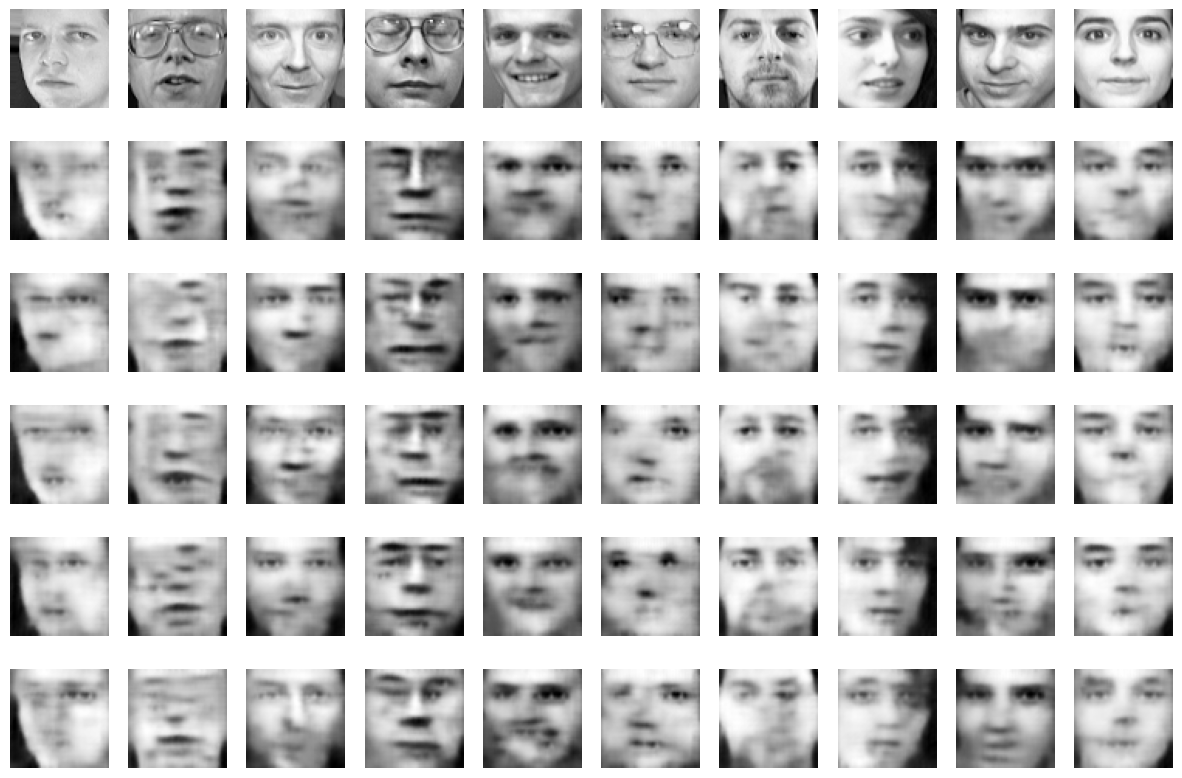

In [ ]:
fig, ax = plt.subplots(6, 10, figsize=(15, 10))

for i in range(10):
  ax[0, i].imshow(input_imgs[i].squeeze(), cmap='gray')
  for j in range(1, 6):
    ax[j, i].imshow(output_imgs[i*5 + (j-1)].squeeze(), cmap='gray')

  for axes in ax[:, i]:
    axes.axis('off')

plt.show()